In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
import pandas as pd
from progressbar import ProgressBar

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

In [2]:
np.random.seed(1)

In [3]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

In [15]:
mean_c1 = (8, 3.5)
cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
c1_sample_no = 500
x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

mean_c2 = (-2.5, -2.5)
cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
c2_sample_no = 500
x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

mean_ood = (-10, -7.5)
cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
ood_sample_no = 200
x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

y_c1 = math_fun(x_c1).reshape(-1, 1)
y_c2 = math_fun(x_c2).reshape(-1, 1)
y_ood = math_fun(x_ood).reshape(-1, 1)

## Create train and test data for each cluster of data
random_state = 1
x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

In [16]:
print ("The minimum value of first cluster: ", np.min(x_c1, axis = 0))
print ("The maximum value of first cluster: ", np.max(x_c1, axis = 0))

print ("The minimum value of second cluster: ", np.min(x_c2, axis = 0))
print ("The maximum value of second cluster: ", np.max(x_c2, axis = 0))

The minimum value of first cluster:  [5.84611907 1.59220601]
The maximum value of first cluster:  [9.74554804 5.46909103]
The minimum value of second cluster:  [-4.34254221 -4.47798003]
The maximum value of second cluster:  [-0.57063556 -0.69654506]


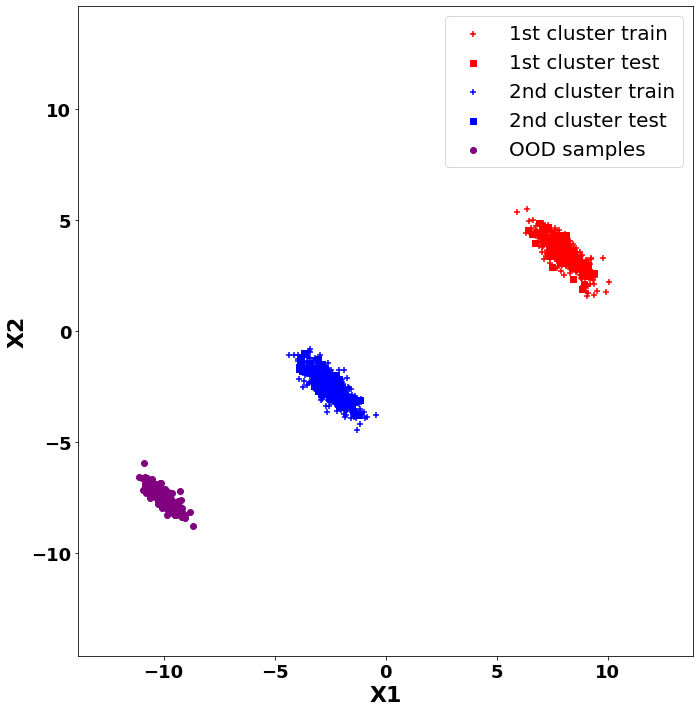

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 's', label='1st cluster test')

plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 's', label='2nd cluster test')

plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

plt.xlabel('X1', fontsize=22, fontweight='bold')
plt.ylabel('X2', fontsize=22, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.legend(fontsize=20)
plt.axis('equal')
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.tight_layout()

In [7]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)

In [8]:
def plot_uncertainty_map(x_mesh, output_std, process=False, contour=False, filename = 'default'):
    std_scaled = output_std/max(output_std)
#     if not spectral_normalization:
#         filename = 'DNN_GP_uncertainty'
#     else:
#         filename = 'SNGP_uncertainty'

#     if process:
#         std_scaled[np.where(std_scaled > 0.7)] = 0.9
#         filename += '_processed'

    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=28)
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

#         filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    plt.savefig(filename + '.pdf', bbox_inches='tight')

## Gaussian Process Regression

In [ ]:
### check how GPR optimizes the length scale parameter 

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                                            n_restarts_optimizer=10)
model_GP.fit(x_train, y_train)

C:\Users\zxgcqupt\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [11]:
print('train error (RMSE):',  rmse(y_train, model_GP.predict(x_train, return_std=False)))

train error (RMSE): 6.298771161146348e-13


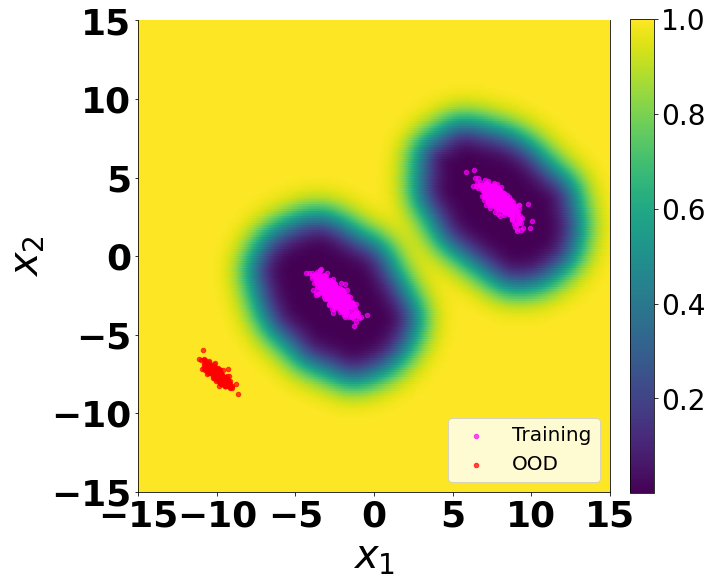

In [12]:
#### Create meshes to verify the uncertainty
n_meshes = 200
x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
x_mesh = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
output, output_std = model_GP.predict(x_mesh, return_std=True)
plot_uncertainty_map(x_mesh, output_std, False, False, 'GP')

## MC Dropout

In [20]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(128, activation = actfn)(feature_input)
    x = Dropout(rate = 0.20)(x)
    
    x = Dense(64, activation = 'relu')(x)
    output = Dense(1, activation = actfn)(x)

    model = Model(feature_input, output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

In [24]:
model_MC = generate_trained_MCmodel(x_train_norm, y_train_norm, 300, 'relu')

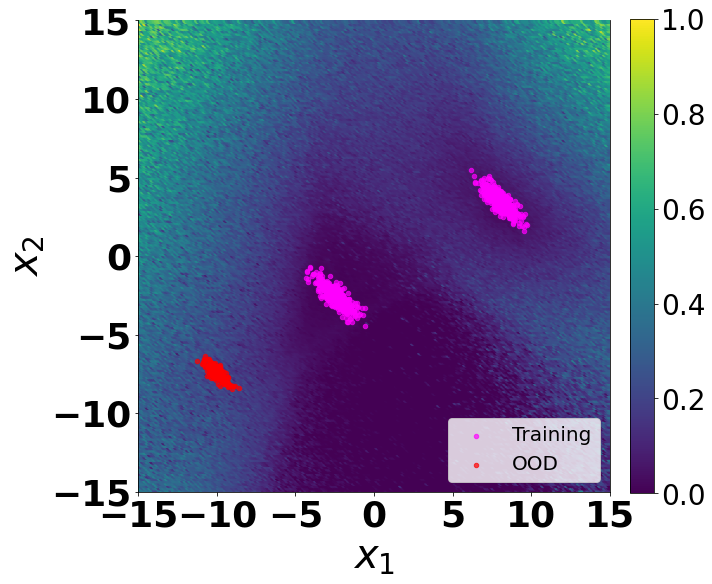

In [25]:
niter = 20
MC_output = np.zeros((len(x_mesh),niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:,i] = scalerY.inverse_transform(K.get_value(model_MC(x_mesh_norm, training=True)))[:,0]
    
plot_uncertainty_map(x_mesh, np.std(MC_output, axis = 1), False, False, 'MC')

In [26]:
MC_output.shape

(40000, 20)

## Deep Ensemble

In [14]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [15]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(20, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x) 
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [16]:
## Create 20 models and select some based on training error
prediction_fns, train_rmse = [], []
nmodels = 20
nepochs = 1000

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(x_train, y_train, nepochs, actfn = 'tanh')
    train_rmse.append(rmse(y_train, my_func(x_train)[0]))
    prediction_fns.append(my_func)
    
nmodels_select = 10
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

100% |########################################################################|


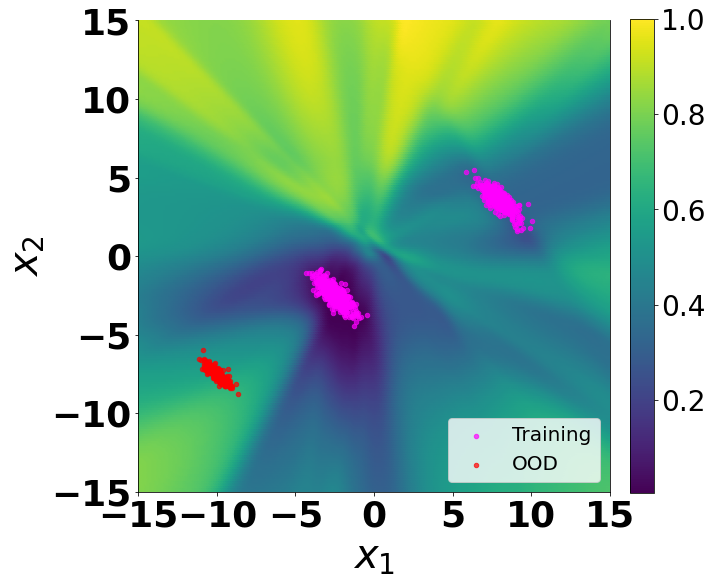

In [19]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                         + np.mean(df[sigma_cols]**2, axis = 1)
                         - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = final_DE_fns[i](x_mesh)[0]
    result_df["DE_sigma_"+str(i)] = np.sqrt(final_DE_fns[i](x_mesh)[1])

result_df = get_ensemble(result_df, "DE", nmodels_select)
plot_uncertainty_map(x_mesh, result_df['DE_sigma_eff'], False, False, 'DE')